In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import csv
import os
import zipfile
from tensorflow.keras import layers, models
import matplotlib.image as mpimg
import random
from PIL import Image
import math

print("All packages imported successfully.")

All packages imported successfully.


In [2]:
metadata_path = "sample_data/metadata.csv"
valid_entries = {}

with open(metadata_path, 'r') as f:
    reader = csv.reader(f)
    for row in reader:
        if len(row) == 5:
            try:
                coords = list(map(float, row[1:5]))
                if sum(coords) != 0:
                    valid_entries[row[0]] = coords
            except:
                pass

print(f"Found {len(valid_entries)} images with valid horizon line labels.")

Found 19809 images with valid horizon line labels.


In [3]:
image_root = "sample_data/images"
test_file = "sample_data/split/test.txt"

# Load filenames
with open(test_file, 'r') as f:
    filenames = [line.strip() for line in f.readlines()]

def file_exists(fname):
    return os.path.exists(f"{image_root}/{fname}")

# Check file is a valid image
def is_valid_image(path):
    try:
        with Image.open(f"{image_root}/{path}") as img:
            img.verify()
        return True
    except:
        return False

# Final filtering
filenames = [f for f in filenames if file_exists(f) and is_valid_image(f)]
print(f"Filtered to {len(filenames)} valid, uncorrupted images.")

# Preprocessing functions
def load_and_preprocess_image(path):
    image = tf.io.read_file(tf.strings.join([image_root, "/", path]))
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    return image

def process_path(path):
    image = load_and_preprocess_image(path)
    image = tf.image.resize(image, [224, 224])

    def get_scaled_label(filename):
        key = filename.numpy().decode()
        x1, y1, x2, y2 = valid_entries[key]
        return np.array([
            (x1 + 5000) * (224 / 10000),
            (y1 + 5000) * (224 / 10000),
            (x2 + 5000) * (224 / 10000),
            (y2 + 5000) * (224 / 10000)
        ], dtype=np.float32)

    label = tf.py_function(get_scaled_label, [path], tf.float32)
    label.set_shape([4])
    return image, label
def scale_gt_for_model(coords):
    # Scale from [-5000, 5000] -> [0, 224]
    return [(x + 5000) * (224 / 10000) if i % 2 == 0 else (y + 5000) * (224 / 10000)
            for i, (x, y) in enumerate(zip(coords[::2], coords[1::2]))]

def get_label(filename):
    key = filename.numpy().decode()
    return tf.constant(valid_entries[key], dtype=tf.float32)

# Build dataset
dataset = tf.data.Dataset.from_tensor_slices(filenames)
dataset = dataset.map(process_path, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)

print("Dataset built successfully.")

Filtered to 2018 valid, uncorrupted images.
Dataset built successfully.


In [4]:
# Load model
model = tf.keras.models.load_model("saved_model/horizon_line_model.keras")
print("Model loaded successfully.")

Model loaded successfully.


[0.0, 929.1808241664, 1365.0, 908.9151332352]
[0.0, 907.7166273555315, 1365.0, 878.7768486115259]



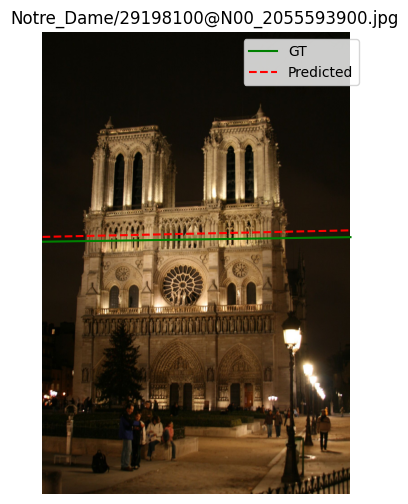

[0.0, 538.0781579074, 1600.0, 547.1650680397]
[0.0, 532.0142127486869, 1600.0, 496.4470669189355]



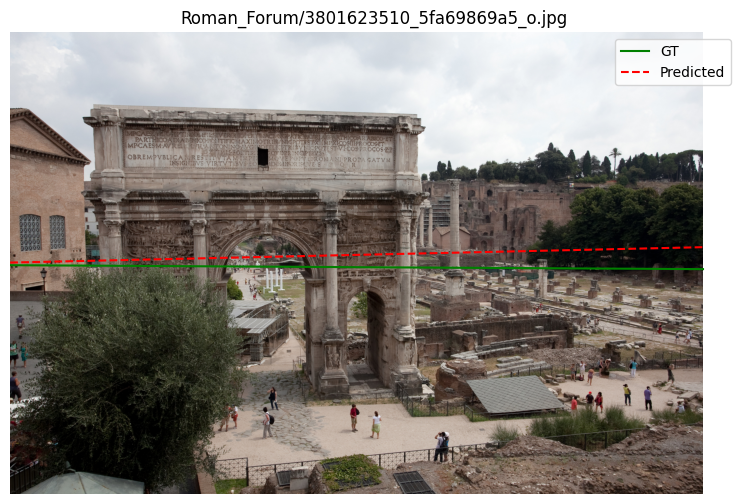

[0.0, 516.13948404, 1600.0, 479.06975004]
[0.0, 526.4787890178513, 1600.0, 505.88550623525873]



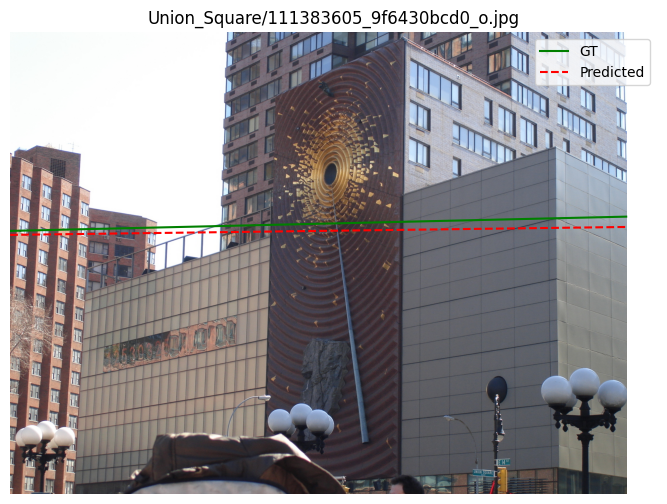

[0.0, 732.9294201600001, 1200.0, 772.3165399999999]
[0.0, 725.4454594967702, 1200.0, 760.4761100434978]



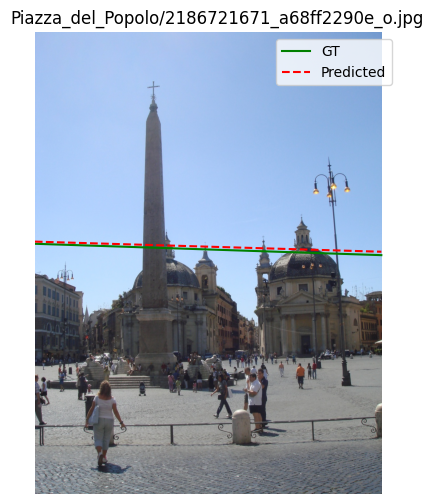

[0.0, 147.9180971749, 448.0, 144.38260845189998]
[0.0, 150.001356419182, 448.0, 126.05821529778632]



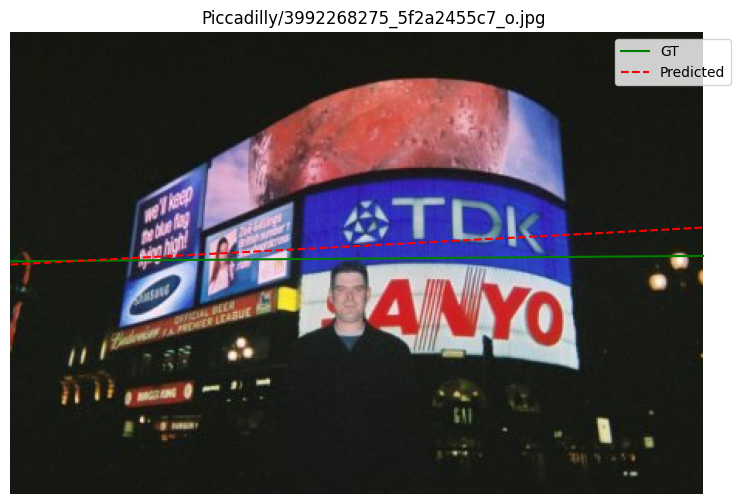

[0.0, 509.01809661119995, 1408.0, 515.9146026144]
[0.0, 465.3507935267372, 1408.0, 422.6249429983722]



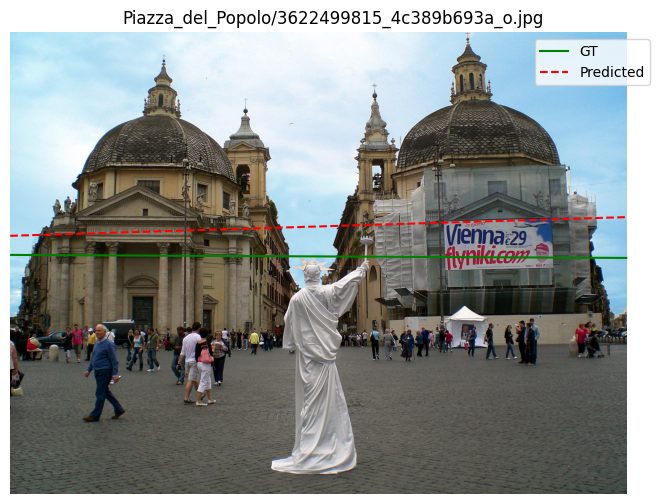

[0.0, 546.972458368, 960.0, 621.89320832]
[0.0, 568.79705337028, 960.0, 552.6948471102834]



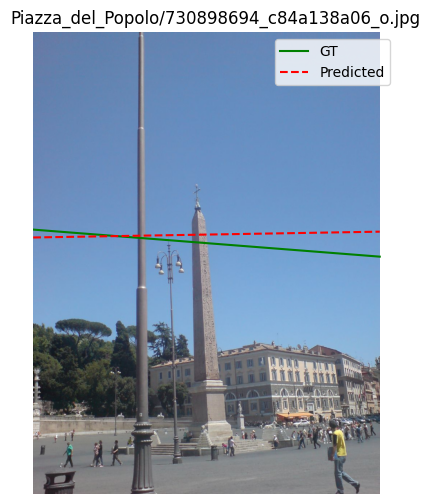

[0.0, 848.4571847999999, 1200.0, 854.8943403200001]
[0.0, 775.8798151251322, 1200.0, 796.2942270361747]



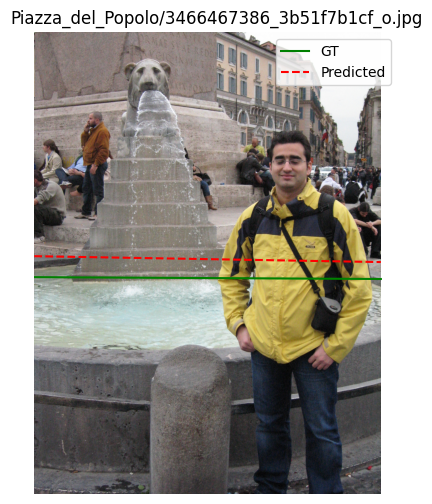

[0.0, 565.6582523999999, 1600.0, 627.14844708]
[0.0, 594.046231877593, 1600.0, 576.3291260324805]



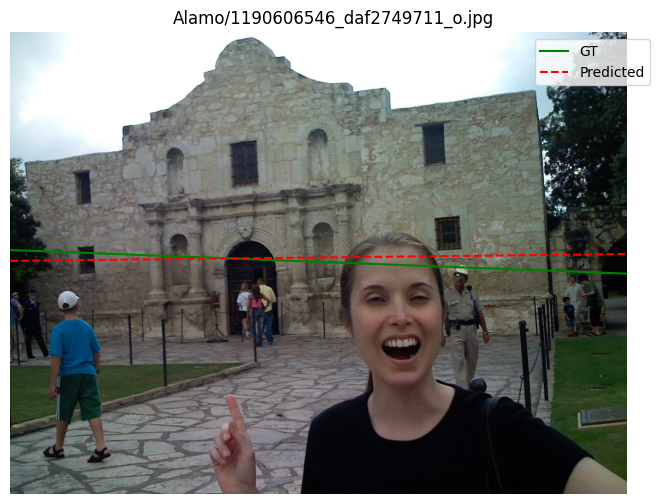

[0.0, 574.8265548, 1600.0, 574.87183812]
[0.0, 570.9913722105262, 1600.0, 557.7683405757929]



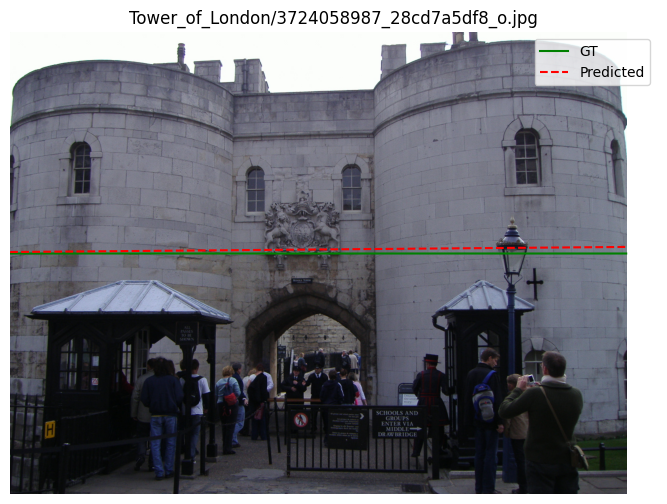

In [13]:
def unscale_prediction(pred):
    return [(x / 224) * 10000 - 5000 for x in pred]

def extend_line_to_full_width(pred):
    x1, y1, x2, y2 = pred

    if x2 == x1:
        # vertical line edge case
        return [-5000, y1, 5000, y2]

    m = (y2 - y1) / (x2 - x1)
    y_left = y1 + m * (-5000 - x1)
    y_right = y1 + m * (5000 - x1)
    return [-5000, y_left, 5000, y_right]

def visualize_prediction(filename):
    # Load image
    img_path = f"{image_root}/{filename}"
    img_raw = mpimg.imread(img_path)
    h, w = img_raw.shape[:2]

    # Load GT
    gt = valid_entries[filename]
    gt_scaled = [
        (gt[0] + 5000) * (w / 10000),
        (gt[1] + 5000) * (h / 10000),
        (gt[2] + 5000) * (w / 10000),
        (gt[3] + 5000) * (h / 10000),
    ]


    # Predict
    inp = load_and_preprocess_image(filename)
    inp = tf.image.resize(inp, [224, 224])
    pred = model.predict(tf.expand_dims(inp, axis=0), verbose=0)[0]
    pred = unscale_prediction(pred)
    
    # 🔧 Extend predicted line to edges
    pred = extend_line_to_full_width(pred)
    
    # Rescale to image coordinates
    pred_scaled = [
        (pred[0] + 5000) * (w / 10000),
        (pred[1] + 5000) * (h / 10000),
        (pred[2] + 5000) * (w / 10000),
        (pred[3] + 5000) * (h / 10000),
    ]

    # Plot
    plt.figure(figsize=(10, 6))
    plt.imshow(img_raw)
    plt.plot([gt_scaled[0], gt_scaled[2]], [gt_scaled[1], gt_scaled[3]], 'g-', label='GT')
    plt.plot([pred_scaled[0], pred_scaled[2]], [pred_scaled[1], pred_scaled[3]], 'r--', label='Predicted')
    plt.title(filename)
    plt.axis('off')
    plt.legend()
    plt.show()

# Try on a few from testt set
for fname in random.sample(filenames, 10):
    visualize_prediction(fname)

In [8]:
# Calculate area between lines in image coordinates
def area_between_lines(gt, pred, image_width, image_height):
    # Sample along x = 0 to x = image_width - 1
    xs = np.linspace(0, image_width - 1, num=image_width)

    def line_y(x, x1, y1, x2, y2):
        if x2 == x1:
            return (y1 + y2) / 2  # vertical line (constant y)
        m = (y2 - y1) / (x2 - x1)
        return m * (x - x1) + y1

    # Convert canonical line to image-space line
    def canonical_to_image_space(x, y):
        x_img = (x + 5000) * (image_width / 10000)
        y_img = (y + 5000) * (image_height / 10000)
        return x_img, y_img

    gt = [canonical_to_image_space(gt[i], gt[i+1]) for i in [0, 2]]
    pred = [canonical_to_image_space(pred[i], pred[i+1]) for i in [0, 2]]

    y_gt = [line_y(x, *gt[0], *gt[1]) for x in xs]
    y_pred = [line_y(x, *pred[0], *pred[1]) for x in xs]

    diffs = np.abs(np.array(y_gt) - np.array(y_pred))
    area = np.sum(diffs)  # Sum of vertical distances (in pixels)

    return area

# Evaluate on test set
area_errors = []

#condense for runtime demonstration
for filename in filenames[:100]:
    try:
        img_path = f"{image_root}/{filename}"
        img_raw = mpimg.imread(img_path)
        h, w = img_raw.shape[:2]

        gt = valid_entries[filename]

        inp = load_and_preprocess_image(filename)
        inp = tf.image.resize(inp, [224, 224])
        pred = model.predict(tf.expand_dims(inp, axis=0), verbose=0)[0]
        pred = extend_line_to_full_width(unscale_prediction(pred))

        error = area_between_lines(gt, pred, w, h)
        area_errors.append(error)
    except Exception as e:
        print(f"Error with file {filename}: {e}")

# Summary
print(f"\nArea Between Lines — Mean: {np.mean(area_errors):.2f, } px, Median: {np.median(area_errors):.2f} px")


Area Between Lines — Mean: 35327.99 px, Median: 27093.97 px
